In this final notebook, we'll try some feature engineering: we will try to convert the spectrum to XYZ and RGB (effectively reducing dimensionality to 3 or less by intelligent guess).

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import stars
from matplotlib import animation


mlflow.sklearn.autolog()
mlflow.set_experiment("/mastar/07_other_models")

hot_id = 61
cold_id = 58

In [3]:
sl = stars.StarLoader()

In [5]:
goodt = sl.get_goodt()
df_goodt = sl.fits_to_pd(goodt)

Let's start with transformation into XYZ. We have already done something similar in notebooks 01 and 02.

In [6]:

xyz = []
rgb = []
for s in goodt:
    star = stars.Star(s)
    xyz.append(star.xyz)
    rgb.append(star.rgb)


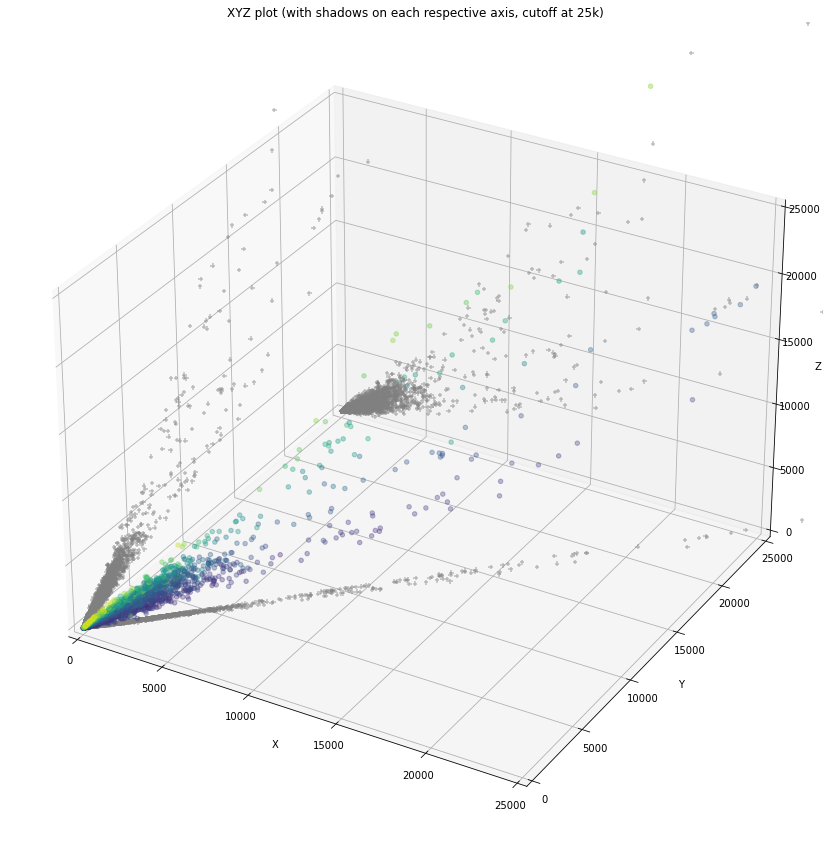

In [7]:
npxyz = np.array(xyz)
df_goodt['x'] = npxyz[:,0].astype(float)
df_goodt['y'] = npxyz[:,1].astype(float)
df_goodt['z'] = npxyz[:,2].astype(float)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_goodt['x'], df_goodt['y'], zdir='z', zs=0.0, color='gray', alpha=0.5, marker='+')
ax.scatter(df_goodt['x'], df_goodt['z'], zdir='y', zs=25000, color='gray', alpha=0.5, marker='+')
ax.scatter(df_goodt['y'], df_goodt['z'], zdir='x', zs=0.0, color='gray', alpha=0.5, marker='+')
ax.scatter(df_goodt['x'], df_goodt['y'], df_goodt['z'], c=df_goodt['teff'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([0.0, 25000])
ax.set_ylim([0.0, 25000])
ax.set_zlim([0.0, 25000])
plt.title('XYZ plot (with shadows on each respective axis, cutoff at 25k)')
plt.show()


In [8]:
training_features_all, testing_features_all, training_target, testing_target = train_test_split(df_goodt, df_goodt['teff'], random_state=seed)

mangaid_training = training_features_all['mangaid']
mangaid_testing = testing_features_all['mangaid']
training_features = np.array(training_features_all[['x', 'y', 'z']])
testing_features = np.array(testing_features_all[['x', 'y', 'z']])

In [9]:
lin = LinearRegression()
pipeline = make_pipeline(
    lin,
    verbose=True
)
pipeline.fit(training_features, training_target)

results = pipeline.predict(testing_features)
mse = mean_squared_error(testing_target, results)
print('MSE: %.2f' % mse)

2022/10/15 16:59:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e7befc88dedd497a98dbec04820ddd68', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[Pipeline] .. (step 1 of 1) Processing linearregression, total=   0.0s


2022/10/15 16:59:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/x/opt/miniconda3/envs/mastar/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


MSE: 1479866.35


MSE of 1.5 million is a pretty poor result compared to other methods.

4D reasoning is hard, so let's try using less dimensions. From the chart above X and Y seem almost completely correlated, so let's use another pair such as X and Z.

In [10]:
training_features_all, testing_features_all, training_target, testing_target = train_test_split(df_goodt, df_goodt['teff'], random_state=seed)

mangaid_training = training_features_all['mangaid']
mangaid_testing = testing_features_all['mangaid']
training_features = np.array(training_features_all[['x', 'z']])
testing_features = np.array(testing_features_all[['x', 'z']])

lin = LinearRegression()
pipeline = make_pipeline(
    lin,
    verbose=True
)
pipeline.fit(training_features, training_target)

results = pipeline.predict(testing_features)
mse = mean_squared_error(testing_target, results)
print('MSE: %.2f' % mse)


2022/10/15 16:59:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7a647983de6d40ac831c2544e2d748e7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[Pipeline] .. (step 1 of 1) Processing linearregression, total=   0.1s
MSE: 1173927.91


1 million MSE is a better result than using all three colour components, but still a far cry from previous methods. But we can now visualise it!

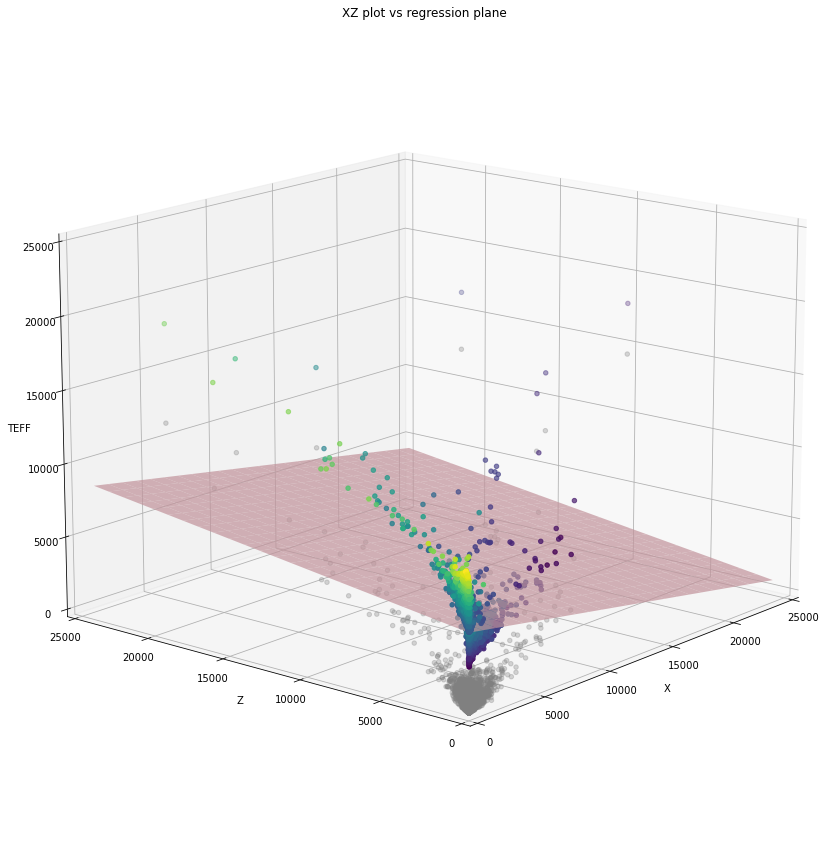

In [11]:

# From https://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function
# Generate 3d surface that represents our linear regression
surf_x = surf_y = np.arange(0.0, 25000.0, 1000.0)
surf_X, surf_Y = np.meshgrid(surf_x, surf_y)
surf_zs = np.array([pipeline.predict([[x,y]]) for x,y in zip(np.ravel(surf_X), np.ravel(surf_Y))])
surf_Z = surf_zs.reshape(surf_X.shape)

goodt_results = pipeline.predict(np.array(df_goodt[['x','z']]))
above = df_goodt[df_goodt['teff']>goodt_results]
below = df_goodt[df_goodt['teff']<=goodt_results]

def update(t, ax):
    ax.view_init(elev=10, azim=10*t)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.scatter(df_goodt['x'], df_goodt['z'], 0, color='gray', alpha=0.3)
ax.scatter(below['x'], below['z'], below['teff'], c=below['teff'])
ax.plot_surface(surf_X, surf_Y, surf_Z, color='pink', alpha=0.7)
ax.scatter(above['x'], above['z'], above['teff'], c=above['teff'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('TEFF')
ax.set_xlim([0.0, 25000])
ax.set_ylim([0.0, 25000])
ax.set_zlim([0.0, 25000])
plt.title('XZ plot vs regression plane')
ax.view_init(elev=15, azim=220)
plt.show()

We can see why this method is failing: while the linear approximation works for stars with significant values of X and Z, there is a lot of stars that are just piled on top of each other at low values of X and Z. They form a sort of twisted surface that starts vertical. This shape prevents us from assigning a meaningful linear function, so a lot of the stars are simply assigned an average. Hence high MSE.

This shows how (relatively) easy it is to reason about low-dimensional linear regression. We have presented all information in a single plot, and we can immediately see why the model works so poorly. We can generate ideas by attempting to visually "fit" different shapes: could we come up with a "twisted" surface function that would fit this pattern? We can also much more easily decide if this is a dead end.

Since XYZ will not give us good results, let's try the same with RGB. This should fare better, because it's normalised.

In [12]:
nprgb = np.array(rgb)
df_goodt['r'] = nprgb[:,0].astype(float)
df_goodt['g'] = nprgb[:,1].astype(float)
df_goodt['b'] = nprgb[:,2].astype(float)

training_features_all, testing_features_all, training_target, testing_target = train_test_split(df_goodt, df_goodt['teff'], random_state=seed)

mangaid_training = training_features_all['mangaid']
mangaid_testing = testing_features_all['mangaid']
training_features = np.array(training_features_all[['r', 'g', 'b']])
testing_features = np.array(testing_features_all[['r', 'g', 'b']])

lin = LinearRegression()
pipeline = make_pipeline(
    lin,
    verbose=True
)
pipeline.fit(training_features, training_target)

results = pipeline.predict(testing_features)
mse = mean_squared_error(testing_target, results)
print('MSE: %.2f' % mse)

2022/10/15 16:59:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9fcd96b41c6046788b5d4552b9556f1a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[Pipeline] .. (step 1 of 1) Processing linearregression, total=   0.0s
MSE: 303687.37


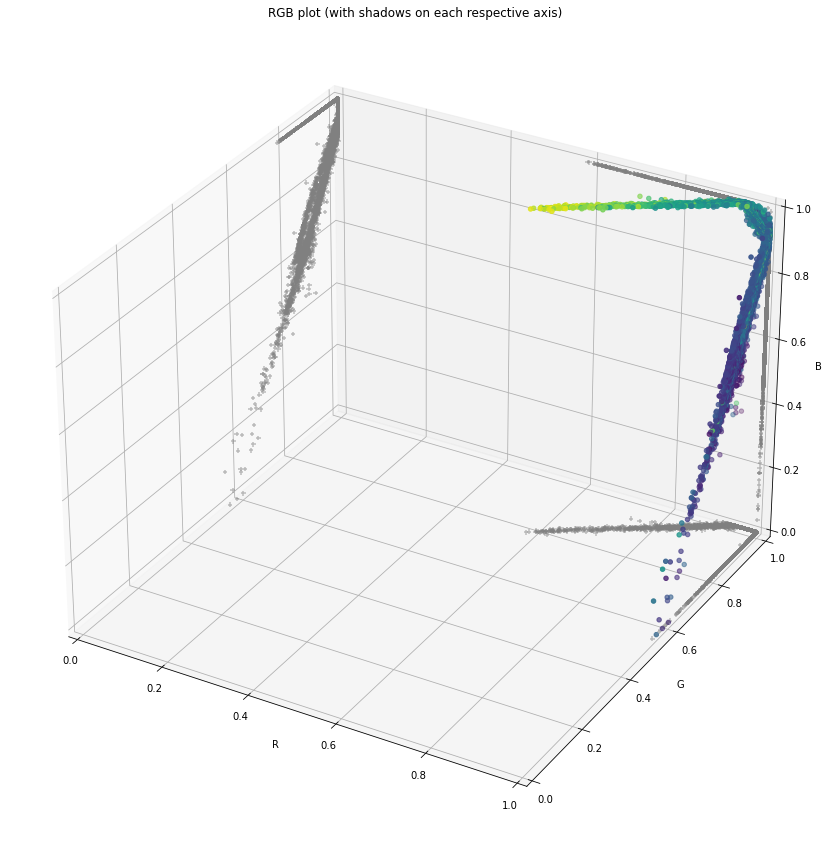

In [13]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_goodt['r'], df_goodt['g'], zdir='z', zs=0.0, color='gray', alpha=0.5, marker='+')
ax.scatter(df_goodt['r'], df_goodt['b'], zdir='y', zs=1.0, color='gray', alpha=0.5, marker='+')
ax.scatter(df_goodt['g'], df_goodt['b'], zdir='x', zs=0.0, color='gray', alpha=0.5, marker='+')
ax.scatter(df_goodt['r'], df_goodt['g'], df_goodt['b'], c=df_goodt['teff'])
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 1.0])
plt.title('RGB plot (with shadows on each respective axis)')
plt.show()

This model gives much better results, and from the chart it's immediately clear why: there is a nice, constant temperature progression as a function of R, G and B. Essentially, we have engineered features that linear regression can easily handle.

Judging by the shadows on the plot, it looks like R and B will give us an equivalent result - and we will be able to plot the regression surface. Let's try it.

In [14]:
training_features_all, testing_features_all, training_target, testing_target = train_test_split(df_goodt, df_goodt['teff'], random_state=seed)

mangaid_training = training_features_all['mangaid']
mangaid_testing = testing_features_all['mangaid']
training_features = np.array(training_features_all[['r', 'b']])
testing_features = np.array(testing_features_all[['r', 'b']])

lin = LinearRegression()
pipeline = make_pipeline(
    lin,
    verbose=True
)
pipeline.fit(training_features, training_target)

results = pipeline.predict(testing_features)
mse = mean_squared_error(testing_target, results)
print('MSE: %.2f' % mse)

2022/10/15 16:59:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '096578fa4a1f4b798e0571e21fe553fa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[Pipeline] .. (step 1 of 1) Processing linearregression, total=   0.0s
MSE: 303382.48


RB gives a similar result to RGB. Here is the regression surface.

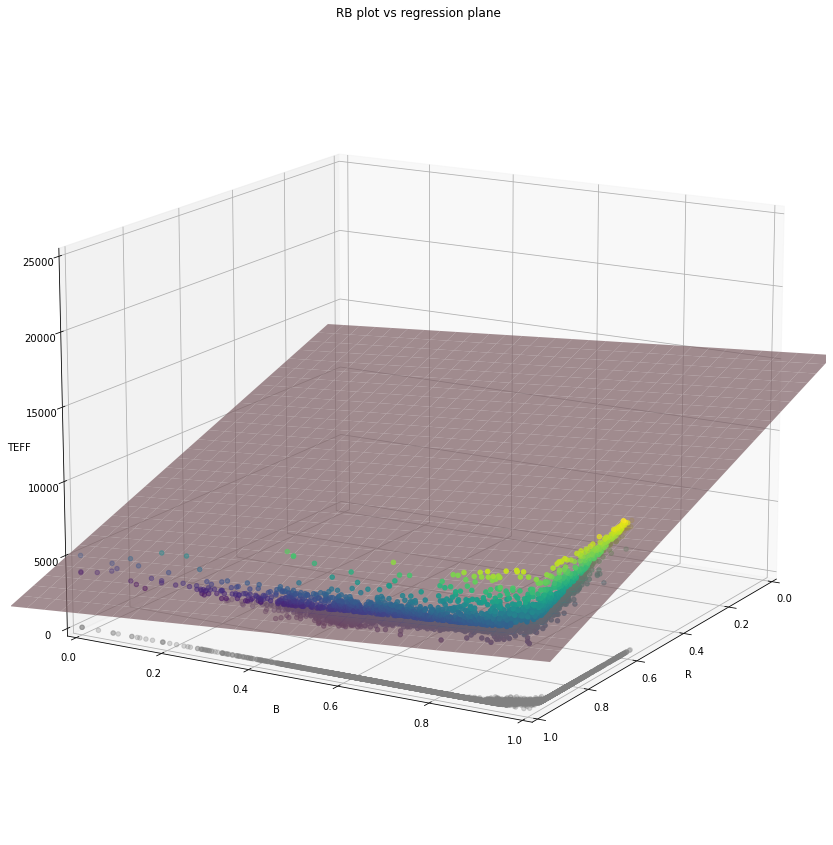

In [15]:
surf_x = surf_y = np.arange(-0.1, 1.1, 0.04)
surf_X, surf_Y = np.meshgrid(surf_x, surf_y)
surf_zs = np.array([pipeline.predict([[x,y]]) for x,y in zip(np.ravel(surf_X), np.ravel(surf_Y))])
surf_Z = surf_zs.reshape(surf_X.shape)

goodt_results = pipeline.predict(np.array(df_goodt[['r','b']]))
above = df_goodt[df_goodt['teff']>goodt_results]
below = df_goodt[df_goodt['teff']<=goodt_results]

def update(t, ax):
    ax.view_init(elev=15, azim=10*t)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.scatter(df_goodt['r'], df_goodt['b'], 0, color='gray', alpha=0.3)
ax.scatter(below['r'], below['b'], below['teff'], c=below['teff'])
ax.plot_surface(surf_X, surf_Y, surf_Z, color='pink', alpha=0.7)
ax.scatter(above['r'], above['b'], above['teff'], c=above['teff'])
ax.set_xlabel('R')
ax.set_ylabel('B')
ax.set_zlabel('TEFF')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 25000])
plt.title('RB plot vs regression plane')
ax.view_init(elev=15, azim=30)
plt.show()

The regression surface fits the overall temperature trend very well. I don't think we can achieve anything more here with more complex surfaces - individual stars show more variance that RGB can help us explain.

This to me highlights the limit of predictive power of the modeling based on spectrum shape (a.k.a. color). I think no other colorspace transformations will help here - our 3-dimensional PCA resulted in similar MSE magnitude (around 280,000, essentially trying to create a custom 3-component colorspace).

MSE of ~300,000 therefore marks the limit beyond which a more fine-grained feature engineering is required. I think this further supports our earlier idea that both lasso and PCA are finding absorption lines in the spectrum. Whatever this specialised method is (we can't tell for sure), it is improving the model by nearly an order of magnitude (from hundred thounsands to tens of thousands MSE).